# Credit card fraud prediction in financial payment services

## Getting familiar with the data

The tricky part about transactional data is that due to the private nature of transactions, there aren't any publicly available datasets. Yet transactional data is still needed for continued research into fraud detection. 

The simulated data used here is based on a simulator called PaySim which helps bridge the gap between unavailable public data and the need to continue improving fraud detection systems. PaySim utilizes aggregated real world data taken from a private dataset to generate synthetic transactional data resembling normal transactions.
This real world data is a sample of real transactions extracted from financial logs from a mobile money service implemented in an African country. More information about the data can be found here: https://www.kaggle.com/ealaxi/paysim1 

The main challenge the dataset poses to predicting fraud is the highly imbalanced distribution between positive and negative classes in 6 million rows of data.


### Dataset Description

1. step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
2. type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
3. amount - amount of the transaction in local currency.
4. nameOrig - customer who started the transaction
5. oldbalanceOrg - initial balance before the transaction
6. newbalanceOrig - new balance after the transaction
7. nameDest - customer who is the recipient of the transaction
8. oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
9. newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
10. isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
11. isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## Our goal

The most common strategy in place for identifying potentially fraudulent transactions is to place a limit on the transaction amount; this is what the Paysim system attempts to do. This approach can work but it does have downsides and can be exploited and negatively impact the customer experience. A more intricate approach is necessary as technology continues to evolve.  

We want to be able to better predict and label fraud transactions when they occur. The current system has a fraud loss of just over 12 billion dollars. The goal is to create a more robust and intelligent classifier to be able to catch these transactions and reduce the fraud loss by 5 billion dollars.

### Data Wrangling

In [2]:
# We can start by importing necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [111]:
# This gives us a first look at the data
df = pd.read_csv('fraud_data.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# We can start by checking for any null values
# We can see that there are no null values!

df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
# A few of the columns we can look at in detail are amount, old and new origin balance, old and new destination balance 

df[['amount', 'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest']].describe()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


In [6]:
# We can also verify the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## EDA (Exploratory Data Analysis)

We can first get a look of a breakdown of our transactions by type

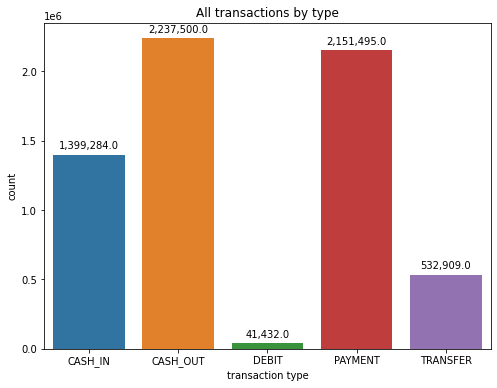

In [7]:
transactions = ['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x = transactions, y = df.groupby('type')['type'].value_counts())
plt.ylabel('count')
plt.xlabel('transaction type')
plt.title('All transactions by type')
for p in ax.patches:
    ax.annotate(format(p.get_height(), ','), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

Of all the transactions above, we can get a better look into the fraudulent ones

Text(0.5, 1.0, 'Confusion matrix for simulator results')

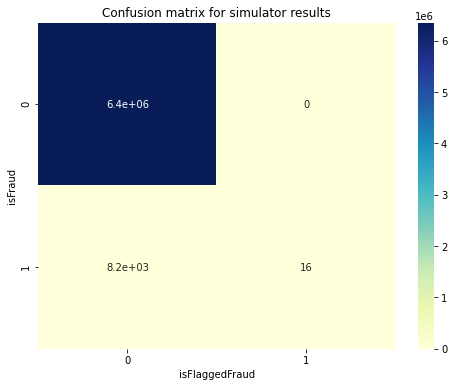

In [8]:
yt_true = list(df['isFraud'])
yt_pred = list(df['isFlaggedFraud'])
cf_matrix = metrics.confusion_matrix(yt_true, yt_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cf_matrix, annot=True, cmap='YlGnBu')
plt.xlabel("isFlaggedFraud")
plt.ylabel("isFraud")
plt.title("Confusion matrix for simulator results")

In [9]:
# Our data contains 8213 fradulent transactions
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

We see that out of over 6 million transactions, only 16 transactions were actually flagged as fraud, and over 8200 were fradulent transactions! The fraud detection system in place is not performing very well. 

Additionally, we see that the fraud transactions are only occuring in either TRANSFER or CASH_OUT types.

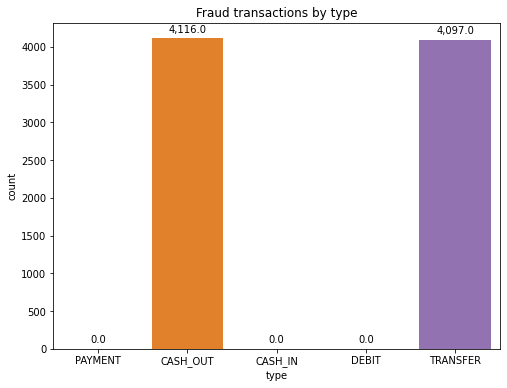

In [10]:
transaction_types = ['PAYMENT', 'CASH_OUT', 'CASH_IN', 'DEBIT', 'TRANSFER']

fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x= transaction_types, y=df.groupby('type')['isFraud'].sum())
plt.title('Fraud transactions by type')
plt.xlabel('type')
plt.ylabel('count')
for p in ax.patches:
    ax.annotate(format(p.get_height(), ','), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

Conclusion:

From the above we see that fraud only occurs when the transaction is either a 'CASH OUT' or 'TRANSFER'. Since the population data is not available to resample, we can reduce our dataset to only CASH OUTS and TRANSFERS.


In [11]:
df = df[(df["type"] == "CASH_OUT") | (df["type"] == "TRANSFER")]

In [12]:
flagged = df[df['isFlaggedFraud'] == 1]

fraud = df[df['isFraud'] == 1]
nonfraud = df[df['isFraud'] == 0]

In [13]:
flagged

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


 Additionally,'isFlaggedFraud' is not related to customers who transact more than once where 'isFlagedFraud' is set.
 We obtain a list of names where there was more than 1 fraud transaction

In [14]:
names = []
multiple_flagged = []

for i in fraud['nameDest'].value_counts().index:
    if fraud['nameDest'].value_counts()[i] > 1:
        names.append(i)
    if i in flagged['nameDest']:
        multiple_flagged.append(i)

In [15]:
# We see that none of the addresses that had multiple fraud transactions were flagged as fraud
print('Addresses with multiple fraud transactions that were flagged: {}'.format(len(multiple_flagged)))

print('Number of addresses with multiple fraud transactions: {}'.format(len(names)))

Addresses with multiple fraud transactions that were flagged: 0
Number of addresses with multiple fraud transactions: 44


After looking at these, we can make the decision to drop the 'isFlaggedFraud' column, for several reasons.

    1. There are only 16 flagged transactions out of over 6 million.
    2. The column does not flag all transfers over 200,000 as fraud, and is not related to transfer type or amount. 
    3. The column is not based on multiple fraud transactions.

In [16]:
df = df.drop(labels='isFlaggedFraud', axis=1)

We see from the documentation that there are two categories of destination columns, Merchant and Customer. 
Merchant recepients were not involved in any of the fraud transactions. Additionally, millions of rows of unique labels would be taxing on our computational time. We can drop the nameorigin and namedest columns as well.

In [17]:
df = df.drop(labels=['nameOrig','nameDest'], axis=1)

In [18]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


### Generating a heatmap to identify feature correlations

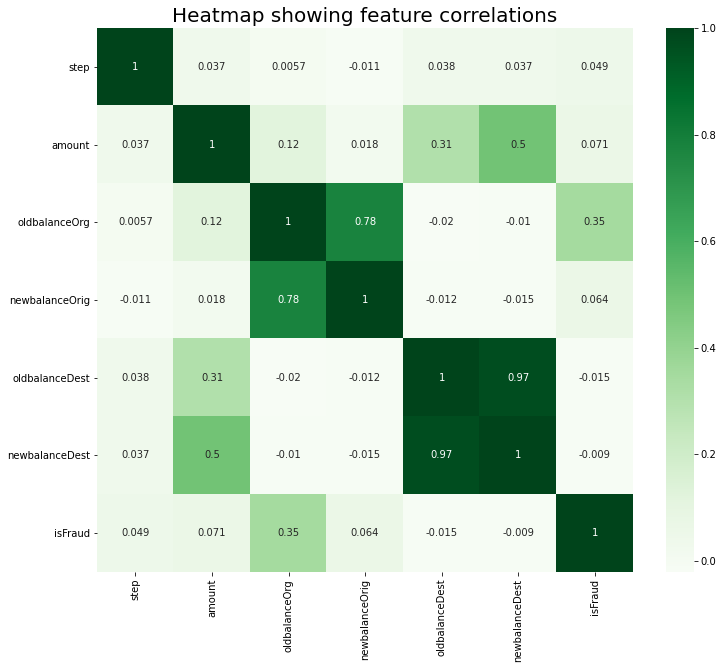

In [19]:
fig, ax = plt.subplots(figsize=(12,10))
_ = sns.heatmap(df.corr(), cmap = 'Greens', annot=True)
_ = plt.title('Heatmap showing feature correlations', fontsize=20)

#### Balance Errors

One thing to notice is that there are numerous columns where the sending and recieving account balances remain at zero even though a positive balance is transacted. We get a better look at that here.

In [20]:
# This is for the originating accounts

diff = len(nonfraud[(nonfraud.oldbalanceOrg == 0) & (nonfraud.newbalanceOrig == 0) & (nonfraud.amount != 0)]) / len(nonfraud)
fraud_diff = len(fraud[(fraud.oldbalanceOrg == 0) & (fraud.newbalanceOrig == 0) & (fraud.amount != 0)]) / len(fraud)

print('Balance error for origin accounts occurs in {}% of valid transactions'.format(round(100*diff, 2)))
print('Balance error for origin accounts occurs in {}% of fraud transactions'.format(round(100*fraud_diff,2)))

Balance error for origin accounts occurs in 47.37% of valid transactions
Balance error for origin accounts occurs in 0.3% of fraud transactions


In [21]:
# This is for the destination accounts

diff = len(nonfraud[(nonfraud.oldbalanceDest == 0) & (nonfraud.newbalanceDest == 0) & (nonfraud.amount != 0)]) / len(nonfraud)
fraud_diff = len(fraud[(fraud.oldbalanceDest == 0) & (fraud.newbalanceDest == 0) & (fraud.amount != 0)]) / len(fraud)

print('Balance error for destination accounts occurs in {}% of valid transactions'.format(round(100*diff, 2)))
print('Balance error for destination accounts occurs in {}% of fraud transactions'.format(round(100*fraud_diff,2)))

Balance error for destination accounts occurs in 0.06% of valid transactions
Balance error for destination accounts occurs in 49.56% of fraud transactions


We use this to help generate features comparing the error balances for both the origin and destination accounts. This is done in the feature engineering section.

#### Amount distributions

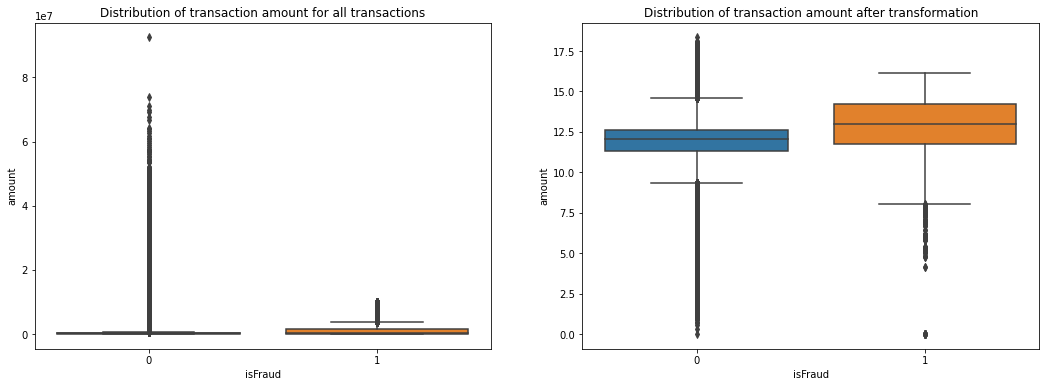

In [22]:
# We first see how the amount transacted is distributed between fraud and nonfraud transactions

# We apply a log transformation to deal with the skewed data

fig, ax = plt.subplots(1,2, figsize=(18,6))
_ = sns.boxplot(x=df.isFraud, y=df.amount, ax=ax[0])
_ = sns.boxplot(x=df.isFraud, y=np.log1p(df.amount), ax=ax[1])
_ = ax[0].title.set_text('Distribution of transaction amount for all transactions')
_ = ax[1].title.set_text('Distribution of transaction amount after transformation')

This helps us visualize how much of an effect the outliers have on the data. We can mitigate the effect of the outliers and get a better idea of the central tendency of the data with the plots below.

#### Transfer and cash out amounts

Since all of our fraud transactions occured in only TRANSFER and CASH_OUT transactions, we can get a better look at those as well.

In [23]:
transfer = df[df['type'] == 'TRANSFER']
cashout = df[df['type'] == 'CASH_OUT']

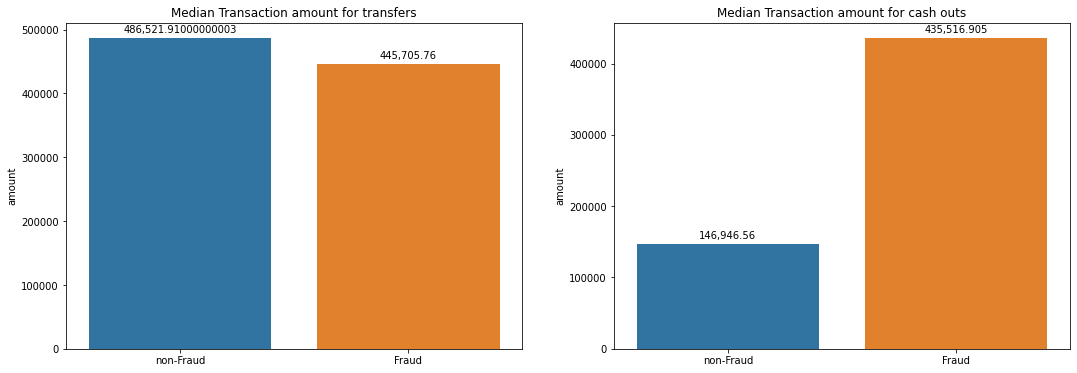

In [24]:
# Here we use median instead of mean to illustrate central tendency in order to suppress the effect of outliers

fig,ax = plt.subplots(1,2,figsize=(18,6))
ax[0].title.set_text("Median Transaction amount for transfers")
ax[1].title.set_text("Median Transaction amount for cash outs")

_ = sns.barplot(x=['non-Fraud', 'Fraud'], y=transfer.groupby('isFraud')['amount'].median(),ax=ax[0])
_ = sns.barplot(x=['non-Fraud', 'Fraud'], y=cashout.groupby('isFraud')['amount'].median(),ax=ax[1])
for i in range(2):
    for p in ax[i].patches:
        ax[i].annotate(format(p.get_height(), ','), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

The median transaction amount in CASH_OUT transactions is almost 3x higher in fraudulent transactions vs nonfraudulent ones. In transfers, the figure is much closer to even.

#### Visualizing a time series

Another aspect of fraud that we can look into is what part of the day it occurs. We can use 'step' to group the transactions into a per day basis to identify if a pattern is present.

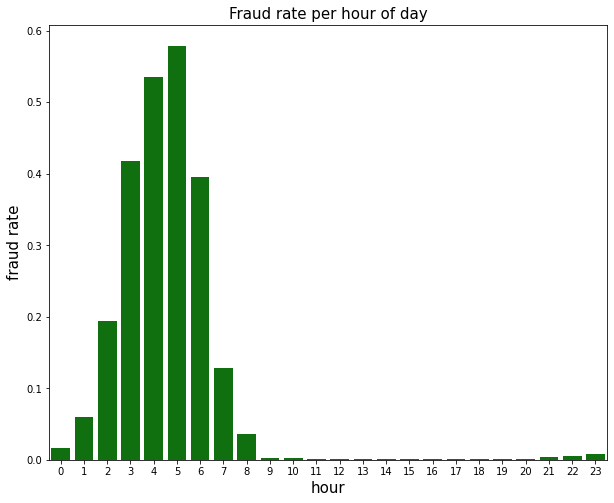

In [25]:
# Here we plot the fradulent transactions on a per hour basis

df['hour'] = df.step % 24
frauds_per_hour = pd.concat([df.groupby("hour")["isFraud"].sum(),df.groupby("hour")["isFraud"].count()],axis=1)
frauds_per_hour.columns = ['num_frauds', 'num_transactions']
frauds_per_hour['fraud_rate'] = frauds_per_hour.num_frauds / frauds_per_hour.num_transactions
_ = plt.subplots(figsize=(10,8))
_ = sns.barplot(x=frauds_per_hour.index, y= frauds_per_hour.fraud_rate, color='green')
_ = plt.title('Fraud rate per hour of day', fontsize=15)
_ = plt.xlabel('hour', fontsize=15)
_ = plt.ylabel('fraud rate', fontsize=15)

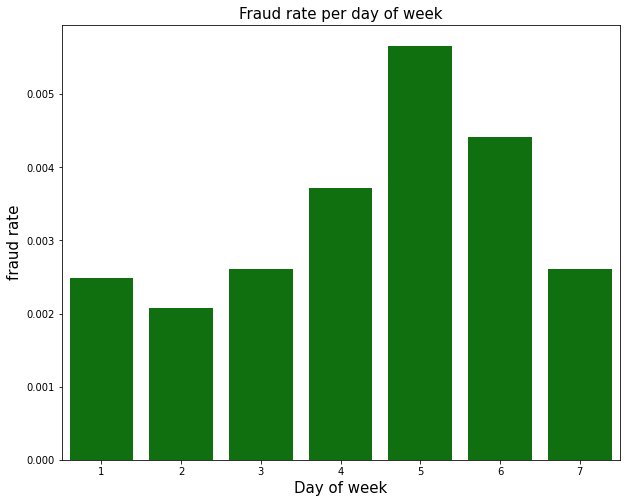

In [26]:
# We can also apply the same concept to visualize fraud rate on a weekly basis

df['dayofmonth'] = round(df.step / 24)
df['dayofweek'] = df['dayofmonth'] % 7
frauds_per_day = pd.concat([df.groupby("dayofweek")["isFraud"].sum(),df.groupby("dayofweek")["isFraud"].count()],axis=1)
frauds_per_day.columns = ['num_frauds', 'num_transactions']
frauds_per_day['fraud_rate'] = frauds_per_day.num_frauds / frauds_per_day.num_transactions
_ = plt.subplots(figsize=(10,8))
_ = sns.barplot(x=list(range(1,8)), y= frauds_per_day.fraud_rate, color='green')
_ = plt.title('Fraud rate per day of week', fontsize=15)
_ = plt.xlabel('Day of week', fontsize=15)
_ = plt.ylabel('fraud rate', fontsize=15)

Two main conclusions from our graphs here. Those are that fraud tends to occur in the early hour of the morning, before 9:00 am, and that it also tends to occur towards the end of the week.

## Feature Engineering

In [27]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour,dayofmonth,dayofweek
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,1,0.0,0.0
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,1,0.0,0.0
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,1,0.0,0.0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,1,0.0,0.0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,1,0.0,0.0


We have several types of features shown in our df now: Datetime features, numerical features, and categorical features. We need to do some work on all of these.

In [28]:
df1 = df.copy()

##### Datetime

The main datetime feature is 'step'. We also created 'hour', 'day', and 'dayofweek'. So this feature has already been addressed. We saw earlier how fraud transaction rates are much higher in the early morning hours and on the later days of the week.

In [29]:
# Those we have already created

df1['hour'] = df1.step % 24
df1['dayofmonth'] = round(df1.step / 24)
df1['dayofweek'] = df1['dayofweek'] % 7

In [30]:
# Lets make the hour feature a binary one for our model.

in_peak_time = []

for i in df1.hour:
    if i in list(range(9)):
        in_peak_time.append(1)
    else:
        in_peak_time.append(0)
        
df1['in_peak_time'] = in_peak_time

In [31]:
df1.in_peak_time.value_counts()

0    2728596
1      41813
Name: in_peak_time, dtype: int64

##### Categorical

The main categorical feature we will focus on here is 'type', since the others have been removed during wrangling. 
Here we can generate dummy variables for the 'type' variable.

In [32]:
df1 = pd.get_dummies(df1,columns=["type"])
df1.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour,dayofmonth,dayofweek,in_peak_time,type_CASH_OUT,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,1,0.0,0.0,1,0,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,1,0.0,0.0,1,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,1,0.0,0.0,1,1,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,1,0.0,0.0,1,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,1,0.0,0.0,1,0,1


In [33]:
baseline_df = df1.copy()

Throughout the dataset, we can pick up on several other trends. Especially when it comes to the fraudulent transactions.

For all the fraudulent transactions:

1. We see that they all follow the same pattern: A 'TRANSFER' of a certain amount followed by a "CASH_OUT' for the same amount immediately after.
2. The 'oldbalanceDest'/'newbalanceDest' is updated (the majority of the time) only after the 'CASH_OUT', not the 'TRANSFER'

We can use this information to generate a new feature that would help our model realize this pattern.

In [34]:
# How many of the fraud transactions are coupled

coupled = 0

for i in range(len(fraud) -1):
    if (fraud.iloc[i].type == 'TRANSFER') & (fraud.iloc[i+1].type == 'CASH_OUT'):
        coupled += 2

print('coupled transactions: {}'.format(coupled))
print('Percentage of fraud transactions that are a part of a coupled transaction: {}'.format((coupled/len(fraud))*100))

coupled transactions: 8182
Percentage of fraud transactions that are a part of a coupled transaction: 99.62254961646171


In [35]:
# How many of all transactions are coupled

df1['coupled'] = 0
coupled = 0

for i in range(len(df1) -1):
    if (df1.iloc[i].type_TRANSFER == 1) & (df1.iloc[i+1].type_CASH_OUT == 1):
        coupled += 1
        df1.coupled.iloc[i] = 1
        df1.coupled.iloc[i+1] = 1
            
print('coupled transactions: {}'.format(coupled))

coupled transactions: 232838


##### Numeric

Here we address the balance error that we saw in the EDA section. 
We can create columns that display the error balance in the origin and destination accounts.

In [36]:
df1["errorBalanceOrg"] = df1.newbalanceOrig + df1.amount - df1.oldbalanceOrg
df1["errorBalanceDest"] = df1.oldbalanceDest + df1.amount - df1.newbalanceDest

#### Train/test split

In [37]:
# Train/test split

X = df1.drop('isFraud', axis=1)
y = df1.isFraud

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42, stratify = df1["isFraud"])

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1939286, 15)
(831123, 15)
(1939286,)
(831123,)


## Modeling

We want to try out several different models and compare which works best. To start we can use a very simple model, a dummy classifier using our base dataframe we saved as baseline_df. This df is not scaled.

With our other df called df1, we have already scaled and performed both undersampling and oversampling. We can use this df to compare other models such as logistic regression, random forest, and XGBoost.

### Simple classifier

In [38]:
# We can start with a simple classifier using our unscaled dataset: baseline_df

X1 = baseline_df.drop('isFraud', axis=1)
y1 = baseline_df.isFraud

X1train, X1test, y1train, y1test = train_test_split(X1,y1, test_size = 0.3, random_state = 42, stratify = df1["isFraud"])

In [39]:
dc = DummyClassifier(random_state=42)
dc.fit(X1train, y1train)
ypred = dc.predict(X1test)
print(classification_report(y1test, ypred))
print(confusion_matrix(y1test, ypred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.00      0.00      0.00      2464

    accuracy                           0.99    831123
   macro avg       0.50      0.50      0.50    831123
weighted avg       0.99      0.99      0.99    831123

[[826178   2481]
 [  2460      4]]


### Logistic Regression

##### Random Sampling

We introduce scaling and undersampling into our models. 

Generally with skewed datasets such as the fraud dataset we are working with we run into the issue of imbalanced data. This imbalanced data influences the performance of a ML model. 
Generally with fraud data this is the case, it would be worrying if the fraud and non fraud data was evenly distributed! 
There are 2 ways to go about this issue, undersampling and oversampling.

Undersampling deletes samples from the majority class.
Oversampling duplicates samples from the minority class. 

Here we use random undersampling since we have a large amount of the majority data. Random sampling is a simple technique that assumes nothing of the data. There are other methods for undersampling and oversampling that may be used if random sampling is deemed too simple. 

##### Scaling

Performing feature scaling is really dependent on which ML model you use. In some cases scaling the features can help model performance, in other cases it does not. 


Gradient descent based algorithms require features to be scaled, and this is why it is used here with logistic regression and with the XGBoost model. On the other hand, tree based algorithms are not affected by scaling, this is why it is not used in the random forest model. 

In [40]:
# We can scale our numeric columns

numeric_features = ['amount', 'oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest', 'errorBalanceOrg', 'errorBalanceDest']
numeric_transformer = Pipeline(steps=[(('scaler', StandardScaler()))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

In [41]:
lr = Pipeline(steps=[('preprocessor', preprocessor),
                     ('usampler',RandomUnderSampler(random_state=42)),
                     ('clf',LogisticRegression(random_state=42))])

parameters = {'usampler__sampling_strategy': [0.6,0.7,0.75,0.8,0.85]}

lr_pipeline = GridSearchCV(lr,parameters,scoring='roc_auc')

# Once optimal parameters are found, we can time the model itself
start = timer()

lr_pipeline.fit(X_train, y_train)
y_predlr = lr_pipeline.predict(X_test)

print(lr_pipeline.best_params_)
print(lr_pipeline.best_score_)

end = timer()
print('Execution time: {} seconds'.format(round(end - start, 3))) 

{'usampler__sampling_strategy': 0.6}
0.9736272615566344
Execution time: 24.055 seconds


In [42]:
print(classification_report(y_test, y_predlr))
print(confusion_matrix(y_test, y_predlr))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    828659
           1       0.06      0.81      0.11      2464

    accuracy                           0.96    831123
   macro avg       0.53      0.88      0.54    831123
weighted avg       1.00      0.96      0.98    831123

[[795704  32955]
 [   472   1992]]


### Decision Tree

In [43]:
start = timer()

dt = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('dt',DecisionTreeClassifier(random_state=42))
])

parameters = {
    'sampler__sampling_strategy': [0.6,0.7,0.75,0.8,0.85],
    'dt__max_depth': [3,5,10]
  }


grid_pipeline1 = GridSearchCV(dt,parameters,scoring='roc_auc')


grid_pipeline1.fit(X_train, y_train)
y_pred22 = grid_pipeline1.predict(X_test)

print(grid_pipeline1.best_params_)
print(grid_pipeline1.best_score_)


end = timer()
print('Execution time: {} seconds'.format(round(end - start, 3))) 

{'dt__max_depth': 5, 'sampler__sampling_strategy': 0.8}
0.9987945634502562
Execution time: 52.588 seconds


In [44]:
print(classification_report(y_test,y_pred22))
print(confusion_matrix(y_test, y_pred22))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.65      1.00      0.79      2464

    accuracy                           1.00    831123
   macro avg       0.83      1.00      0.89    831123
weighted avg       1.00      1.00      1.00    831123

[[827362   1297]
 [     9   2455]]


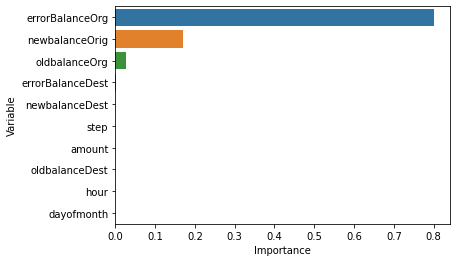

In [45]:
imp = pd.DataFrame({"Variable":list(X_train.columns),"Importance":grid_pipeline1.best_estimator_['dt'].feature_importances_})
imp = imp.sort_values("Importance",ascending=False)
sns.barplot(x=imp.Importance.head(10),y=imp.Variable.head(10))

### Random Forest

In [46]:
start = timer()

rf = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('rf',RandomForestClassifier(random_state=42, class_weight='balanced'))
])

parameters = {
    'sampler__sampling_strategy': [0.6,0.7,0.75,0.8, 0.85],
    'rf__n_estimators':[1,10,100],
    'rf__max_depth': [3,5,7,10]
  }


grid_pipeline1 = GridSearchCV(rf,parameters, scoring='roc_auc')

grid_pipeline1.fit(X_train, y_train)
y_predrf = grid_pipeline1.predict(X_test)

print(grid_pipeline1.best_params_)
print(grid_pipeline1.best_score_)


end = timer()
print('Execution time: {} seconds'.format(round(end - start, 3))) 

{'rf__max_depth': 7, 'rf__n_estimators': 10, 'sampler__sampling_strategy': 0.75}
0.9993993348121547
Execution time: 466.498 seconds


In [47]:
print(classification_report(y_test, y_predrf))
print(confusion_matrix(y_test, y_predrf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.95      1.00      0.97      2464

    accuracy                           1.00    831123
   macro avg       0.98      1.00      0.99    831123
weighted avg       1.00      1.00      1.00    831123

[[828542    117]
 [     9   2455]]


In [53]:
# We can compare the RF using the dataframe without our two most important features, to see how this impacts results

start = timer()

rf1 = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('rf1',RandomForestClassifier(random_state=42))])
parameters = {
    'sampler__sampling_strategy': [0.75],
    'rf1__n_estimators':[10],
    'rf1__max_depth': [7]}

grid_pipeline2 = GridSearchCV(rf1,parameters, scoring='roc_auc')
grid_pipeline2.fit(X1train, y1train)
y_predrf1 = grid_pipeline2.predict(X1test)

print(grid_pipeline2.best_params_)
print(grid_pipeline2.best_score_)

end = timer()
print('Execution time: {} seconds'.format(round(end - start, 3))) 

{'rf1__max_depth': 7, 'rf1__n_estimators': 10, 'sampler__sampling_strategy': 0.75}
0.9948559003667704
Execution time: 6.123 seconds


In [54]:
print(classification_report(y_test, y_predrf1))
print(confusion_matrix(y_test, y_predrf1))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    828659
           1       0.17      0.93      0.29      2464

    accuracy                           0.99    831123
   macro avg       0.58      0.96      0.64    831123
weighted avg       1.00      0.99      0.99    831123

[[817356  11303]
 [   168   2296]]


Taking those two features away really affects our results. Now there are over 11,000 fraud transactions that were labeled as valid with this model. 

##### Random Forest without undersampling

In [100]:
start = timer()

rf = Pipeline([
    ('rf',RandomForestClassifier(random_state=42, class_weight='balanced'))])

parameters = {
    'rf__n_estimators':[10],
    'rf__max_depth': [7]}

grid_pipeline3 = GridSearchCV(rf,parameters, scoring='roc_auc')

grid_pipeline3.fit(X_train, y_train)
y_predrf = grid_pipeline1.predict(X_test)

print(grid_pipeline3.best_params_)
print(grid_pipeline3.best_score_)


end = timer()
print('Execution time: {} seconds'.format(round(end - start, 3))) 

{'rf__max_depth': 7, 'rf__n_estimators': 10}
0.9991610600872202
Execution time: 127.724 seconds


In [101]:
print(classification_report(y_test, y_predrf))
print(confusion_matrix(y_test, y_predrf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.99      1.00      0.99      2464

    accuracy                           1.00    831123
   macro avg       1.00      1.00      1.00    831123
weighted avg       1.00      1.00      1.00    831123

[[828643     16]
 [     9   2455]]


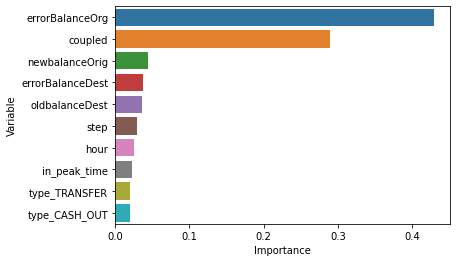

In [102]:
imp = pd.DataFrame({"Variable":list(X_train.columns),"Importance":grid_pipeline1.best_estimator_['rf'].feature_importances_})
imp = imp.sort_values("Importance",ascending=False)
sns.barplot(x=imp.Importance.head(10),y=imp.Variable.head(10))

### Gradient Boosting

In [55]:
start = timer()

xgb = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('xgb',GradientBoostingClassifier(random_state=42, max_features='sqrt'))
    ])

parameters = {
    'sampler__sampling_strategy': [0.6, 0.7, 0.75, 0.8, 0.85],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__n_estimators': [1, 100, 500],
    'xgb__max_depth': [3,5,7,10]
}

grid_pipeline = GridSearchCV(xgb,parameters, scoring='roc_auc')

grid_pipeline.fit(X_train, y_train)
y_pred_gb = grid_pipeline.predict(X_test)

print(grid_pipeline.best_params_)
print(grid_pipeline.best_score_)


end = timer()
print('Execution time: {} seconds'.format(round(end - start, 3))) 

{'sampler__sampling_strategy': 0.85, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 500}
0.9995837202631005
Execution time: 1783.839 seconds


In [56]:
print(classification_report(y_test, y_pred_gb))
print(confusion_matrix(y_test,y_pred_gb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.86      1.00      0.92      2464

    accuracy                           1.00    831123
   macro avg       0.93      1.00      0.96    831123
weighted avg       1.00      1.00      1.00    831123

[[828252    407]
 [     8   2456]]


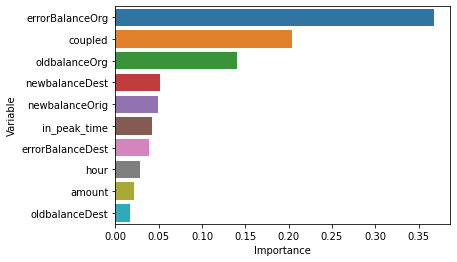

In [57]:
imp = pd.DataFrame({"Variable":list(X_train.columns),"Importance":grid_pipeline.best_estimator_['xgb'].feature_importances_})
imp = imp.sort_values("Importance",ascending=False)
sns.barplot(x=imp.Importance.head(10),y=imp.Variable.head(10))

## Model evaluation

In classification problems such as this, accuracy is not the best metric to use in order to evaluate model performance. Looking at AUC would be more appropriate. 

The main metric used to measure model performance was AUC. The AUC is a plot of the true positive rate (Ratio of valid transactions that were classified as valid) vs the false positive rate (Ratio of fraud transactions that were classified as valid). The perfect AUC would then be 1, where every valid transaction was correctly classified. 

In [72]:
# Logistic Regression
print('AUC for logistic regression model: {}'.format(roc_auc_score(y_test, y_predlr)))

AUC for logistic regression model: 0.8843362428795339


In [74]:
# Decision Tree
print('AUC for logistic regression model: {}'.format(roc_auc_score(y_test, y_pred22)))

AUC for logistic regression model: 0.9973911115965439


In [103]:
# Random Forest
print('AUC for random forest model: {}'.format(roc_auc_score(y_test, grid_pipeline3.best_estimator_.predict(X_test))))

AUC for random forest model: 0.9981640471466315


In [78]:
# Gradient boosting
print('AUC for Gradient Boost model: {}'.format(roc_auc_score(y_test, grid_pipeline.best_estimator_.predict(X_test))))

AUC for Gradient Boost model: 0.998131045883348


#### Winning model

From the information acquired from our models, we can see that the best performing ones are the random forest and the gradient boosted model. Choosing which model to use depends on the business case at hand. 
In each model tested, we used cross validation to optimize parameters via GridSearchCV. 

The AUC for the Random Forest model (0.998), Gradient Boost model (0.998), and even decision tree model (0.997) all are very similar. In this case, we can look at the confusion matrix to get a breakdown of how the labels were assigned in the testing data. Precision would also be a good metric to look at, it also helps differentiate each models performance.

Looking further at the confusion matrices shows us that the Random Forest is the winning model over the two since it has far fewer false negatives and thus a higher recall score. The false positive rate in the winning random forest model is also much lower than the others.

#### Conclusion

The model the existing business had in place only flagged only 16 out of 8213 fraud transactions. Through the development here, the model created was able to correctly identify 99.8% of fraud transactions. If this model had already been in place, this would have resulted in flagging 8,183 of the 8213 fraud transactions.

The 8213 fraud transactions resulted in a loss of 12,056,415,427.83 out of a total transactional volume of 1,144,392,944,759.77.

With the random forest model in place to identify fraudulent transactions, this would have prevented the loss of around 3,612,168,009.